# Building Permit Metrics of San Francisco

## Packages & Raw Data Import

In [1]:
import geopandas as gpd
import pandas as pd

import os 
os.chdir(r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics')

Import in San Francisco Neighborhoods and Quadrants

In [2]:
path = r'raw_data\sf_neighborhoods.geojson'
sfnhood = gpd.read_file(path)

path = r'raw_data\sf_quadrants.geojson'
sfquad = gpd.read_file(path)

### Import San Francisco Building Permits 2016-2022
Pre-Cleaned Accela Permits from SF Open Data Portal ([pre-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-before-January-1-2013/)
 or [post-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-on-or-after-January-1-2013/))

Column Metadata to rename columns & determine which ones to keep

In [5]:
path = r'static_data\metadata\sf_permit_metadata.xlsx'
sfp_meta = pd.read_excel(path)

new_col_names = {
    old.lower():new for old,new in sfp_meta[['Column Name','New Name']].values 
    if type(new) == str
}
keep_cols = sfp_meta.loc[sfp_meta['Keep']=='y', 'Column Name'].str.lower().to_list() + ['geometry']

Import in geojson of geolocated & cleaned permits

In [6]:
import pandas as pd
import geopandas as gpd

path = r'raw_data\sf_planning_permits_20220321.geojson'
sfp_full = gpd.read_file(path)

Prepare Dataset:
1. Filter by 'Project Profile' permits *(which are the 'main' permit)* & columns
2. Rename columns with metadata
3. Set integer & date type columns
4. Filter by permits with some form of proposed units
5. Remove Empty Geometry
6. Filter permits by:
    * A Start Date of Mid-2014
    * A Close Date of Mid-2015
7. Join to Neighborhoods

In [20]:
# 1. FILTER BY PERMIT TYPE
prj_filt = sfp_full['record_type']=='PRJ'
sfp = sfp_full[prj_filt][keep_cols].copy()

# 2. RENAME COLUMNS
sfp.columns = [
    new_col_names[c] if c in new_col_names.keys()
    else c
    for c in list(sfp)
]

# 3. SET DATA TYPES
## INTEGERS
unit_col = [c for c in list(sfp) if '#' in c]
sfp[unit_col] = sfp[unit_col].astype(float).astype(int)
## DATES
date_col = [c for c in list(sfp) if 'date' in c]
sfp[date_col] = sfp[date_col].apply(pd.to_datetime)

# 4. FILTER BY UNITS
all_filt = sfp['#units_prop']>0
mr_filt = sfp['#units_prop_mr']>0
sfp = sfp[all_filt|mr_filt]

# 5. REMOVE EMPTY GEOMETRY
sfp = sfp[~sfp['geometry'].is_empty] 
sfp_all = sfp.copy()

# 6. SET DATES 
## OPEN DATE OF 2014
date_open = '2014Q3'
open_filt = sfp['date_open']>date_open
## CLOSE DATE OF MID-2015
date_close = '2015Q3'
close_filt = sfp['date_close'].dt.to_period("Q")>=date_close
sfp = sfp[open_filt&close_filt]

# 7. JOIN TO NEIGHBORHOODS
sfp = sfp.sjoin(sfnhood).drop(columns='index_right')

## Exploratory Data Analysis

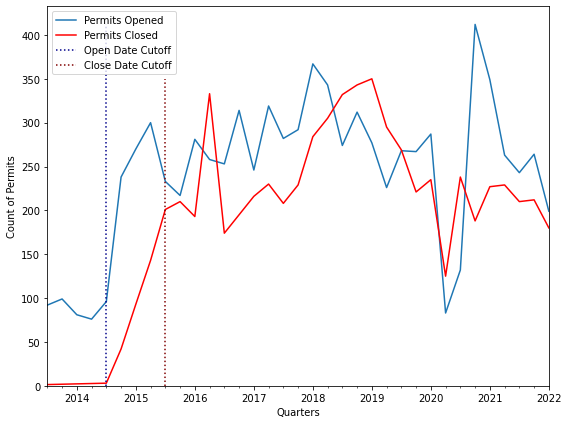

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

date_open = '2014Q3'
date_close = '2015Q3'

fig  = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

def date_group(date_col, period = 'Q', group_df = sfp_all):
    return group_df.sort_values(date_col).groupby(group_df[date_col].dt.to_period(period))['id'].count()

date_col = 'date_open'
open_df = date_group(date_col)
open_df.plot(ax=ax, kind="line", label='Permits Opened')
#date_group(date_col, period="Y").plot(ax=ax, color='black', kind="bar")

date_col = 'date_close'
close_df = date_group(date_col)
close_df.plot(ax=ax, color='red', kind="line", label='Permits Closed')

ax.set_xlim(['2013Q3',None])
ax.set_ylim([0,None])

col = 'darkblue'
ax.vlines(
    x=date_open, ymin=0, ymax=max(open_df), colors=col, ls=':',
    label = 'Open Date Cutoff')
#ax.hlines(y=max(open_df), xmin=date_open, xmax=max(open_df.index), colors=col, ls=':')

col = 'maroon'
ax.vlines(
    x=date_close, ymin=0, ymax=max(close_df), colors=col, ls=':',
    label = 'Close Date Cutoff'
    )
#ax.hlines(y=max(close_df), xmin=date_close, xmax=max(close_df.index), colors=col, ls=':')

ax.set_xlabel('Quarters')
ax.set_ylabel('Count of Permits')
ax.legend(loc='best')

plt.show()

Period('2022Q1', 'Q-DEC')

In [ ]:
#sfp[sfp['date_open']>='2015-01-01'].count()
#sfp[sfp['date_open']<'2015-01-01'].count()

sfp['date_openclose'] = sfp['date_open'].astype(str) + sfp['date_close'].astype(str)

sfp['length'] = (sfp['date_close'] - sfp['date_open']).dt.days
#(sfp['length']/365).hist()

long_plot = sfp.dropna(subset=['date_open','date_close'])

#fig  = plt.figure(figsize = (8,6))
#ax = fig.add_subplot(111)

period = 'Q'
#ax.barh(
#    long_plot.date_open.dt.to_period(period), 
#    long_plot.date_close.dt.to_period(period), 
#    left=long_plot.date_open.dt.to_period(period))


In [35]:
a = sfp['date_app_acc'].dropna().count()
t = len(sfp)

a/t

unit_max = 100000
sjp_join = sfp[sfp['#units_prop']<unit_max].copy()

sfp_nhood = sjp_join.groupby('nhood')['id'].count().to_dict()
sfnhood['permit_count'] = sfnhood['nhood'].map(sfp_nhood).fillna(value=0).astype(int)


sfp_unit = sjp_join.groupby('nhood')['#units_prop'].sum().to_dict()
sfnhood['unit_prop_count'] = sfnhood['nhood'].map(sfp_unit).fillna(value=0)

sjp_join['unit_per_permit'] = sjp_join['#units_prop']/1
sfp_upp = sjp_join.groupby('nhood')['unit_per_permit'].median().to_dict()
sfnhood['unit_per_permit'] = sfnhood['nhood'].map(sfp_upp).fillna(value=0)

In [36]:
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase

class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})

def set_label(
    bins,
    zero = True,
    binder = '-'
    ):
    binder = ' {} '.format(binder)

    if zero == True:
        bins = [0] + bins

    bins = list(zip(bins[:-1],bins[1:]))

    def to_string(pair):
        paired = str(pair[0]) + binder + str(pair[1])
        return paired

    bins = [to_string(bin) for bin in bins]
    bins = [
        '0' if bin == '0' + binder + '0'
        else bin 
        for bin in bins
        ]
    return bins

def set_legend(leg, new_texts, location=2):
    
    leg._loc = location

    for lbl,new_text in zip(leg.get_texts(), new_texts):
        label_text = lbl.get_text()
        #lower = label_text.split()[0]
        #upper = label_text.split()[2]
        #new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
        lbl.set_text(new_text)

C:\Users\nelms\AppData\Local\Temp\ipykernel_7428\3268762778.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)
C:\Users\nelms\AppData\Local\Temp\ipykernel_7428\3268762778.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)


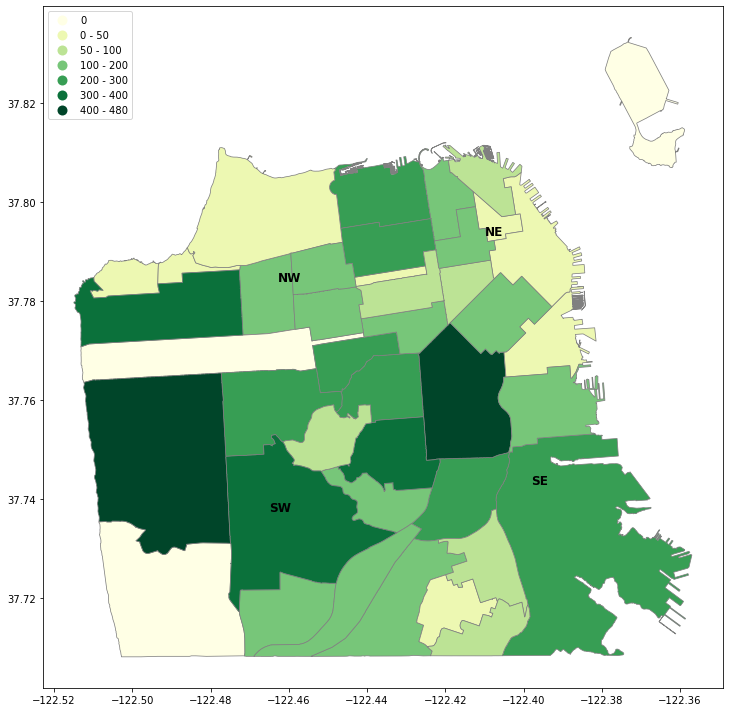

In [37]:
plot_col = 'permit_count'

map_bin = dict(bins=[0,50,100,200,300,400, sfnhood[plot_col].max()])

ax = sfnhood.plot(
    column=plot_col, 
    cmap='YlGn', 
    figsize=(40, 10), 
    scheme='User_Defined',
    classification_kwds=map_bin, k=len(map_bin)-1, 
    legend=True, linewidth=0.75, edgecolor='grey')

sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)
for x, y, label in sfquads:
    ax.annotate(
        label, xy=(x, y), xytext=(3, 3), 
        textcoords="offset points",
        fontsize='large',
        fontweight='bold'
        )

leg = ax.get_legend()
set_legend(leg, set_label(map_bin['bins']))

In [ ]:
sfnhood['permit_count'].hist()

In [ ]:
from matplotlib.text import Text
from matplotlib.legend import Legend

handles = list(string.ascii_uppercase)[:N] 
labels = [f"Model Name {c}" for c in handles]

fig, ax = plt.subplots()
ax.scatter(x, y, s=100, c=colors, alpha=0.5)
for i, xy in enumerate(zip(x, y)):
    ax.annotate(handles[i], xy=xy)

ax.legend(handles=handles, labels=labels)

In [ ]:
sfp.sort_values('#units_prop', ascending=False).head(30)

In [ ]:
path = r'static_data\sf_permit_acronyms.xlsx'
sfp_acr = pd.read_excel(path)
sfp_acr = {
    acr:name for acr,name in sfp_acr.set_index('Acronym')['Name'].to_dict().items()
    if type(acr) == str
}